In [32]:
import config
import pandas as pd
import time
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
from kneed import KneeLocator
from IPython.display import IFrame
from helpers import play_song
from helpers import get_playlist_tracks
from helpers import load

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

In [33]:
def play_song(track_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+track_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

## Loading songs from csv file

In [34]:
df_tracks1 = pd.read_csv('songs1.csv')
df_tracks2 = pd.read_csv('songs.csv')
df_tracks3 = pd.read_csv('listofaudio.csv')

df_tracks = pd.concat([df_tracks1,df_tracks2,df_tracks3],axis=0)

In [35]:
df_tracks

,Unnamed: 0,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,duration_ms,artist,song,key,mode,type,uri,track_href,analysis_url,time_signature
0,0,0.634,0.77500,-4.090,0.0346,0.00856,0.000000,0.2800,0.5390,123.977,...,183710,Tiësto,On My Way,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.738,0.90100,-2.212,0.0452,0.07060,0.013900,0.0753,0.6460,109.987,...,183784,Galantis,Rich Boy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.409,0.82900,-6.250,0.1710,0.02000,0.011200,0.3400,0.3070,159.914,...,210000,Blvk Sheep,Run,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.607,0.64900,-6.695,0.0362,0.03060,0.000025,0.1740,0.5050,102.996,...,247627,The Chainsmokers,Something Just Like This,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,0.597,0.86700,-5.384,0.0557,0.02000,0.000006,0.7430,0.0539,127.944,...,199907,KSHMR,Voices,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64095,64095,0.477,0.00669,-36.430,0.0518,0.99500,0.908000,0.0591,0.2580,128.611,...,137707,NaN,NaN,5.0,1.0,audio_features,spotify:track:4UjMKBpI6ukfH31WCfeh4O,https://api.spotify.com/v1/tracks/4UjMKBpI6ukf...,https://api.spotify.com/v1/audio-analysis/4UjM...,4.0
64096,64096,0.310,0.15600,-22.460,0.0411,0.99400,0.879000,0.0894,0.3780,87.922,...,244093,NaN,NaN,9.0,0.0,audio_features,spotify:track:1UEDMKbWoJqaD91bRC8iZx,https://api.spotify.com/v1/tracks/1UEDMKbWoJqa...,https://api.spotify.com/v1/audio-analysis/1UED...,3.0
64097,64097,0.394,0.01300,-25.399,0.0538,0.97700,0.970000,0.1310,0.2680,78.927,...,42867,NaN,NaN,3.0,1.0,audio_features,spotify:track:7yD1pjo3OfslfWikXPGcAR,https://api.spotify.com/v1/tracks/7yD1pjo3Ofsl...,https://api.spotify.com/v1/audio-analysis/7yD1...,4.0
64098,64098,0.355,0.04430,-24.512,0.0355,0.99400,0.882000,0.1090,0.1490,76.587,...,198427,NaN,NaN,0.0,1.0,audio_features,spotify:track:2hNbUtLFQxp0uQ3fKju16M,https://api.spotify.com/v1/tracks/2hNbUtLFQxp0...,https://api.spotify.com/v1/audio-analysis/2hNb...,3.0


In [36]:
df_tracks.drop(['Unnamed: 0','duration_ms'], axis=1, inplace=True)

In [37]:
df_tracks_num = df_tracks.select_dtypes(include=np.number)

In [38]:
df_tracks_num = df_tracks_num.sort_index(axis=1)
df_tracks_num.drop(['key','mode','time_signature'],axis=1,inplace=True)

In [39]:
scaler = StandardScaler()
scaler.fit(df_tracks_num)

tracks_scaled = scaler.transform(df_tracks_num)
df_tracks_num_scaled = pd.DataFrame(tracks_scaled, columns = df_tracks_num.columns)

In [40]:
df_tracks_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82940 entries, 0 to 64099
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      82940 non-null  float64
 1   danceability      82940 non-null  float64
 2   energy            82940 non-null  float64
 3   instrumentalness  82940 non-null  float64
 4   liveness          82940 non-null  float64
 5   loudness          82940 non-null  float64
 6   speechiness       82940 non-null  float64
 7   tempo             82940 non-null  float64
 8   valence           82940 non-null  float64
dtypes: float64(9)
memory usage: 6.3 MB


In [41]:
with open("Model/scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)

In [42]:
df_tracks_num = df_tracks_num.drop_duplicates()

## Model Training 

Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 

Training a K-Means model with 20 clusters! 



Text(0.5, 1.0, 'Elbow Method showing the optimal k')

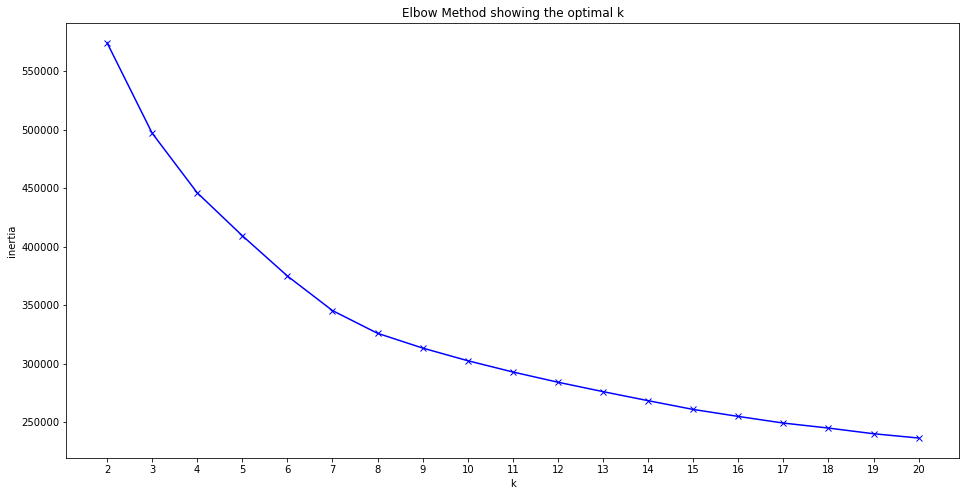

In [43]:
K = range(2, 21)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(df_tracks_num_scaled)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [44]:
kneedle = KneeLocator(K, inertia, S=1.0, curve="convex", direction="decreasing")

In [45]:
kneedle.elbow

8

In [46]:
kmeans = KMeans(n_clusters=8, random_state=1234)
kmeans.fit(df_tracks_num_scaled)

KMeans(random_state=1234)

In [47]:
labels = kmeans.labels_

## Adding cluster labels to the main dataframe

In [48]:
df_tracks['cluster'] = labels.tolist()

In [49]:
with open("Model/kmeans.pickle", "wb") as f:
    pickle.dump(kmeans,f)

## Function that recommends a song from the same cluster as user entry

In [52]:
def song_recommender():
    
    print(""" This Program recommends a similar song based on user entry """)
    
    time.sleep(3)



    usersong = input('####### ENTER A SONG ######################\n\n')
    song = []
    artist = []
    ids = []
    results = sp.search(q=usersong,limit=5,market="GB")
    for item in results['tracks']['items']:
        song.append(item['name'])
        artist.append(item['artists'][0]['name'])
        ids.append(item['id'])
        d=list(zip(song,artist,ids))
        info = pd.DataFrame(d,columns=['SONG', 'ARTIST','id'])
        info.index += 1
        info_show = info[['SONG','ARTIST']]

    display(info_show)

    q = int(input('#######  PRESS A NUMBER TO CHOOSE A SONG ########'))


    track_id1 = info.loc[q]['id']
    
    



    audio_features = sp.audio_features(track_id1)[0]

    list_of_features = []

    for i in audio_features:
        list_of_features.append(audio_features[i])
    df_user = pd.DataFrame(columns=['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                                    'type', 'id', 'uri', 
                                    'track_href', 'analysis_url', 'duration_ms', 'time_signature'])

    df_user.loc[0] = list_of_features

    df_user = df_user[["danceability","energy","loudness","speechiness","acousticness",
        "instrumentalness","liveness","valence","tempo"]]

    df_user = df_user.sort_index(axis=1)

    scaler2 = load("Model/scaler.pickle")

    user_scaled  = scaler2.transform(df_user)

    df_user_scaled = pd.DataFrame(user_scaled, columns = df_user.columns)

    model = load("Model/kmeans.pickle")

    cluster_of_user = model.predict(df_user_scaled)[0]

    track_id = df_tracks[df_tracks['cluster'] == cluster_of_user].sample()['id']

    track_id = list(track_id)[0]

    print('########## RECOMMENDATION ###############################\n')

    return play_song(track_id)

In [53]:
usersong = input('####### ENTER A SONG ######################\n\n')
song = []
artist = []
ids = []
results = sp.search(q=usersong,limit=5,market="GB")
for item in results['tracks']['items']:
    song.append(item['name'])
    artist.append(item['artists'][0]['name'])
    ids.append(item['id'])
    d=list(zip(song,artist,ids))
    info = pd.DataFrame(d,columns=['SONG', 'ARTIST','id'])
    info.index += 1
    info_show = info[['SONG','ARTIST']]

print(info_show)

q = int(input('#######  PRESS A NUMBER TO CHOOSE A SONG ########'))


track_id1 = info.loc[q]['id']
play_song(track_id1)

####### ENTER A SONG ######################




HTTP Error for GET to https://api.spotify.com/v1/search with Params: {'q': '', 'limit': 5, 'offset': 0, 'type': 'track', 'market': 'GB'} returned 400 due to No search query


SpotifyException: http status: 400, code:-1 - https://api.spotify.com/v1/search?q=&limit=5&offset=0&type=track&market=GB:
 No search query, reason: None

In [55]:
song_recommender()

 This Program recommends a similar song based on user entry 
####### ENTER A SONG ######################

mind over matter kollegah


,SONG,ARTIST
1,MIND OVER MATTER,Kollegah
2,OLIGARCH,Kollegah
3,MIND KONTROL,Kollegah
4,Mind Over Matter,LOOK MUM NO COMPUTER
5,MONOPOL,Kollegah


#######  PRESS A NUMBER TO CHOOSE A SONG ########1
########## RECOMMENDATION ###############################

